# Fly on ball: minimal working example for hackathon

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import PIL.ImageDraw

from dm_control import mujoco
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums

from dm_control.mujoco.wrapper import mjbindings
mjlib = mjbindings.mjlib

In [2]:
# Function to generate video.

from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation

def display_video(frames, framerate=30):
    """
    Args:
        frames (array): (n_frames, height, width, 3)
        framerate (int)
    """
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


# Load fly model and make some changes to it:
* Weld fly model to world (to imitate tethered fly)
* Add ball
* Remove "surprising collisions"

In [5]:
# Load model (as mjcf model).
# xml_path = 'path/to/fruitfly.xml'
xml_path = '/groups/turaga/home/vaxenburgr/code/fly_control/fly_control/walkers/assets/fruitfly_v2/fruitfly.xml'


mjcf_model = mjcf.from_path(xml_path)

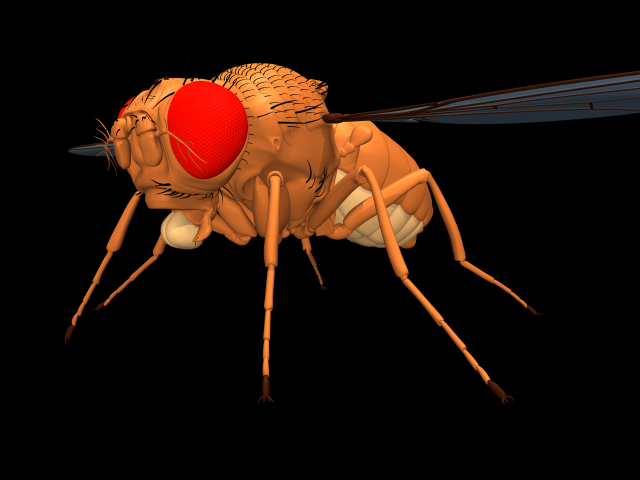

In [6]:
# Visualize fly as loaded.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)

pixels = physics.render(camera_id=0, width=640, height=480)
PIL.Image.fromarray(pixels, mode="RGB")

In [7]:
# Load model (again, just in case) and make modifications to it.

mjcf_model = mjcf.from_path(xml_path)

# Add texture and material for ball.
texture = mjcf_model.asset.add('texture', rgb1=[.2, .3, .4], rgb2=[.1, .2, .3],
                               type='2d', builtin='checker', name='groundplane',
                               width=200, height=200,)
material = mjcf_model.asset.add('material', name='ballsurface', texrepeat=[2, 2],  # Makes white squares exactly 1x1 length units.
                                texuniform=True,
                                reflectance=0.2,
                                texture=texture)

# Remove freejoint.
freejoint = mjcf_model.find('joint', 'free')
if freejoint is not None:
    freejoint.remove()
    
# == Add ball.
radius = 1.5  # Pick ball radius.
# Calculate ball position wrt fly given ball radius.
claw_T1_left = np.array([0.09178167, 0.08813114, -0.12480448])
ball_x = -0.05
ball_z = - np.sqrt(radius**2 - claw_T1_left[0]**2 - (ball_x - claw_T1_left[1])**2) + claw_T1_left[2]
ball = mjcf_model.worldbody.add('body', name='ball', pos=(ball_x, 0, ball_z))
ball.add('geom', type='sphere', size=(radius, 0, 0), density=0.01, material=material)  # Density of water in cgs == 1.
ball_joint = ball.add('joint', name='ball', type='ball')

# Exclude "surprising collisions".
for child in mjcf_model.find('body', 'thorax').all_children():
    if child.tag == 'body':
        mjcf_model.contact.add('exclude', name=f'thorax_{child.name}', body1='thorax', body2=child.name)

In [8]:
# Sanity check, should be equal to ball radius selected above.
np.sqrt((ball_z - claw_T1_left[2])**2 + (ball_x - claw_T1_left[0])**2 + claw_T1_left[1]**2)

1.5001216793980412

In [9]:
# Compile modified model.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)

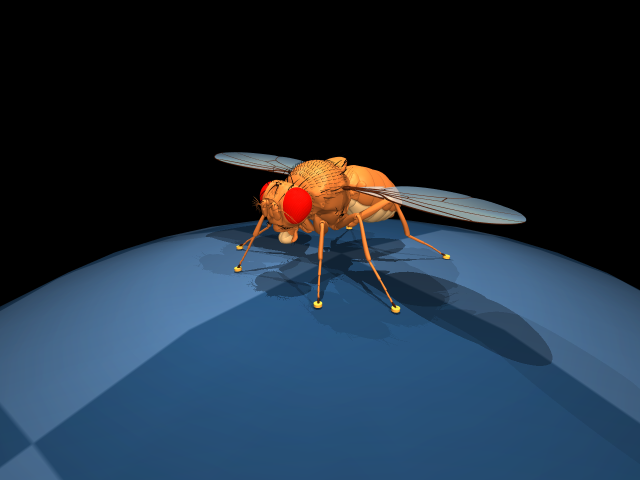

In [10]:
# Visualize new modified fly model on ball.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_CONTACTPOINT] = True

pixels = physics.render(camera_id=1, width=640, height=480,
                        scene_option=scene_option)
PIL.Image.fromarray(pixels)

# Run small simulation: move legs randomly and make movie

In [11]:
# Get indices for leg actuators (to avoid moving the entire body).
act_indices = []
for i in range(physics.model.nu):
    name = physics.model.id2name(i, 'actuator')
    if 'coxa' in name or 'femur' in name or 'tibia' in name or 'tarsus' in name:
        act_indices.append(i)

In [12]:
# Run simulation and make movie.

# Set initial state.
with physics.reset_context():
    # Initial ball velocioty.
    physics.named.data.qvel['ball'] = [0, -1., 0]
    # Retract wings.
    for side in ['left', 'right']:
        physics.named.data.qpos[
            [f'wing_yaw_{side}',
             f'wing_roll_{side}',
             f'wing_pitch_{side}']] = [1.5, 0.7, -1.0]

# Run simulation.
timestep_ratio = 10
n_act = len(act_indices)
frames = []
for i in range(2000):
    if i % timestep_ratio == 0:
        action = np.random.uniform(-0.7, 0.7, size=n_act)
        physics.data.ctrl[act_indices] = action
        pixels = physics.render(camera_id=1, width=640, height=480, 
                                scene_option=scene_option)
        frames.append(pixels)
    physics.step()


In [13]:
# Watch movie and smile:)
display_video(frames)